기본 라이브러리

In [68]:
import pandas as pd
import numpy as np
from datetime import time
import math
import folium
# 시각화 라이브러리
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import seaborn as sns
%matplotlib inline

In [69]:
df = pd.read_excel('C:/Users/wnrrh/desktop/data/model_K.xlsx',header=0)

In [70]:
columns = ['시설명','시간대구분','주소','도로명','행정동','행정동 별 인구','면적','인구밀도','자치구','시설종류','구역지정수',
           '보호구역도로폭','CCTV설치여부','CCTV 수','도로표지판 수','과속방지턱 수','위도','경도','tmp','속도','총생활인구수',
           '사망자수','중상자수','경상자수','부상신고자수','가해운전자 차종','피해운전자 차종',
           '피해운전자 연령', '사고 수','통행량 도로명','통행량','오전/오후','등하교시간','출퇴근시간','속도준수여부','주변보호구역유무'
          ]
df.columns = columns

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36240 entries, 0 to 36239
Data columns (total 36 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   시설명       36240 non-null  object 
 1   시간대구분     36240 non-null  int64  
 2   주소        36240 non-null  object 
 3   도로명       36240 non-null  object 
 4   행정동       36240 non-null  object 
 5   행정동 별 인구  36240 non-null  int64  
 6   면적        36240 non-null  float64
 7   인구밀도      36240 non-null  int64  
 8   자치구       36240 non-null  object 
 9   시설종류      36240 non-null  object 
 10  구역지정수     36240 non-null  int64  
 11  보호구역도로폭   36240 non-null  float64
 12  CCTV설치여부  36240 non-null  int64  
 13  CCTV 수    36240 non-null  int64  
 14  도로표지판 수   36240 non-null  float64
 15  과속방지턱 수   36240 non-null  int64  
 16  위도        36240 non-null  float64
 17  경도        36240 non-null  float64
 18  tmp       36240 non-null  object 
 19  속도        36240 non-null  float64
 20  총생활인구수    36240 non-null  fl

In [72]:
# 파생변수 (의사결정나무를 통한)

# 시간대 관련
df['오전/오후'] = df['시간대구분'].apply(lambda x: 1 if (12<=x<=23) else 0)
df['등하교시간'] = df['시간대구분'].apply(lambda x: 1 if (7<=x<=9) | (15<=x<=17) else 0)
df['출퇴근시간'] = df['시간대구분'].apply(lambda x: 1 if (7<=x<=10) | (17<=x<=19) else 0)
df['점심시간'] = df['시간대구분'].apply(lambda x: 1 if (12<=x<=13) else 0)
df['일출/일몰'] = df['시간대구분'].apply(lambda x: 1 if (6<=x<=18) else 0)
df['활동시간'] = df['시간대구분'].apply(lambda x:1 if x>7.5 else 0)

# 속도 관련
df['속도준수여부'] = df['속도'].apply(lambda x:1 if x<=30 else 0)

# CCTV 관련
df.loc[df['CCTV 수'] == 0, 'CCTV설치여부'] = 0
df.loc[df['CCTV 수'] > 0, 'CCTV설치여부'] = 1

# 차종 관련
df['가해차종125cc이상'] = df['가해운전자 차종'].apply(lambda x: 1 if (3.973<=x) else 0)
df['피해차종엔진유무'] = df['피해운전자 차종'].apply(lambda x: 1 if (x<=6.021) else 0)
df['가해차종4륜유무'] = df['가해운전자 차종'].apply(lambda x: 1 if (x>4.477) else 0)

# 연령 관련
df['어린이 피해 여부'] = df['피해운전자 연령'].apply(lambda x: 1 if (1<=x<=13.333) else 0)
df['고령자 피해 여부'] = df['피해운전자 연령'].apply(lambda x: 1 if (x<=76.804) else 0)
df['피해자교통수단탑승유무'] = df['피해운전자 차종'].apply(lambda x:1 if (x<6.021) else 0)
df['보호구역초등학교여부'] = df['시설종류'].apply(lambda x: 1 if (x=='초등학교') else 0)
df['피해자연령38세이하'] = df['피해운전자 연령'].apply(lambda x : 1 if (x<=38.453) else 0)
df['피해차량승합차량여부'] = df['피해운전자 차종'].apply(lambda x:1 if (x<=1.537) else 0)
df['일방통행여부'] = df['보호구역도로폭'].apply(lambda x:1 if (x<4.749) else 0)

# 보호구역 현황 관련
df['최적의 구역지정 여부'] = df['구역지정수'].apply(lambda x: 1 if x<=2.5 else 0)
df['1차선 이하'] = df['보호구역도로폭'].apply(lambda x: 1 if x<=7.9 else 0)
df['최적의 과속방지턱 수'] = df['과속방지턱 수'].apply(lambda x: 1 if x<=43.5 else 0)
df['표지판 8개이하'] = df['도로표지판 수'].apply(lambda x: 1 if x<=8.012 else 0)
df['CCTV 3개이하'] = df['CCTV 수'].apply(lambda x:1 if x<=3 else 0)

# 인구밀도 관련 
df['인구밀집 수준'] = df['인구밀도'].apply(lambda x:1 if 2138.936<=x else 0)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36240 entries, 0 to 36239
Data columns (total 55 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   시설명          36240 non-null  object 
 1   시간대구분        36240 non-null  int64  
 2   주소           36240 non-null  object 
 3   도로명          36240 non-null  object 
 4   행정동          36240 non-null  object 
 5   행정동 별 인구     36240 non-null  int64  
 6   면적           36240 non-null  float64
 7   인구밀도         36240 non-null  int64  
 8   자치구          36240 non-null  object 
 9   시설종류         36240 non-null  object 
 10  구역지정수        36240 non-null  int64  
 11  보호구역도로폭      36240 non-null  float64
 12  CCTV설치여부     36240 non-null  int64  
 13  CCTV 수       36240 non-null  int64  
 14  도로표지판 수      36240 non-null  float64
 15  과속방지턱 수      36240 non-null  int64  
 16  위도           36240 non-null  float64
 17  경도           36240 non-null  float64
 18  tmp          36240 non-null  object 
 19  속도  

In [ ]:
# 반경 350M 이내 보호구역
df["주변보호구역유무"]=0
for i in range(len(df)):
    for j in range(len(df)):
        if 0<haversine((df.loc[i,"위도"],df.loc[i,"경도"]),(df.loc[j,"위도"],df.loc[j,"경도"]))<=0.35:
            df.loc[i,"주변보호구역유무"]=1
            break

위험도에 들어가는 변수 전부 Min-Max Scaling 처리

In [73]:
def MinMax(x):
    _max = x.max()
    _min = x.min()
    _denominator = _max - _min
    return (x- _min) / _denominator
df['사망자수'] = MinMax(df['사망자수'])
df['중상자수'] = MinMax(df['중상자수'])
df['경상자수'] = MinMax(df['경상자수'])
df['부상신고자수'] = MinMax(df['부상신고자수'])

In [75]:
# 위험도 산정
df['위험도'] = 0
for i in range(len(df)):
    df.loc[i,'위험도'] = df.loc[i,'사망자수']*15.39 + df.loc[i,'중상자수']*7.847 + df.loc[i,'경상자수']*3.87 + df.loc[i,'부상신고자수']*1.901+df.loc[i,'통행량']

C:\Users\wnrrh\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '위험도 분포')

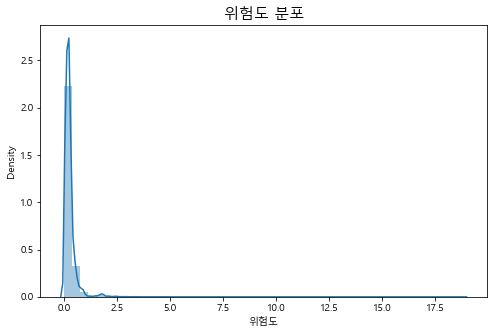

In [76]:
# 산정한 위험도 분포
plt.figure(figsize=(8,5))
sns.distplot(df['위험도'])
plt.title('위험도 분포',fontdict={'fontsize':15})

In [77]:
df['위험도'].describe()

count    36240.000000
mean         0.273421
std          0.410934
min          0.000000
25%          0.122484
50%          0.215212
75%          0.300350
max         18.829941
Name: 위험도, dtype: float64

In [78]:
## k-means clustering
from sklearn.cluster import KMeans
features = ['위험도']

X = df[features]
X_train = pd.get_dummies(X)

model = KMeans(n_clusters=3, random_state=0)
model.fit(X_train)
y_pred = model.labels_

df['cluster_label'] = y_pred

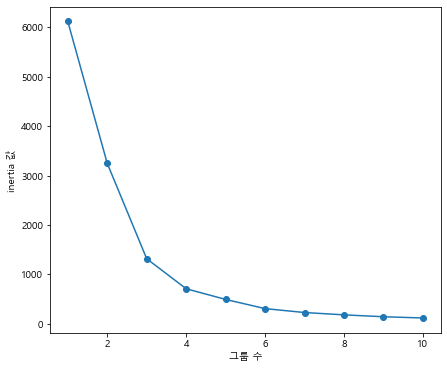

In [79]:
# 군집 수 확인 
inertia_list = []
for k in range(1,11):
    model = KMeans(n_clusters=k)
    model.fit(X)
    inertia_list.append(model.inertia_)
plt.figure(figsize=(7,6))
plt.plot(range(1,11), inertia_list, marker='o')
plt.xlabel("그룹 수")
plt.ylabel("inertia 값")
plt.show()

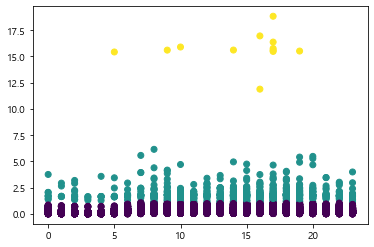

In [80]:
plt.scatter(x = df["시간대구분"], y = df["위험도"], c=y_pred)

In [81]:
print(df['총생활인구수'].corr(df['위험도']))

-0.008715417706750802


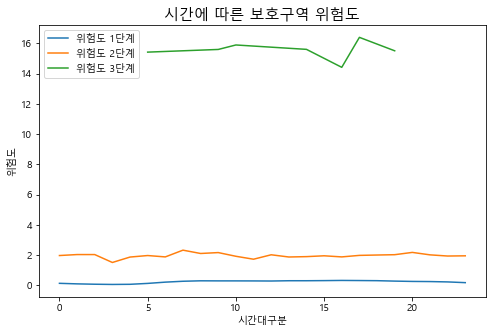

In [82]:
# 클러스터링 결과 시각화
plt.figure(figsize = (8,5))
sns.lineplot(data=df[df['cluster_label']==0],x='시간대구분', y='위험도', ci=None, label='위험도 1단계')
sns.lineplot(data=df[df['cluster_label']==1],x='시간대구분', y='위험도', ci=None, label='위험도 2단계')
sns.lineplot(data=df[df['cluster_label']==2],x='시간대구분', y='위험도', ci=None, label='위험도 3단계')
# sns.lineplot(data=df[df['cluster_label']==3],x='시간대구분', y='위험도', ci=None, label='위험도 4단계')
# sns.lineplot(data=df[df['cluster_label']==4],x='시간대구분', y='위험도', ci=None, label='위험도 5단계')
plt.title('시간에 따른 보호구역 위험도',fontdict = {'fontsize':15})
plt.legend()
plt.show()

In [83]:
df['위험도 군집'] = df['cluster_label'].apply(lambda x :1 if x==0 else (2 if x==1 else 3))

In [84]:
df['위험도 군집'].value_counts()

1    35584
2      644
3       12
Name: 위험도 군집, dtype: int64

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36240 entries, 0 to 36239
Data columns (total 58 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   시설명            36240 non-null  object 
 1   시간대구분          36240 non-null  int64  
 2   주소             36240 non-null  object 
 3   도로명            36240 non-null  object 
 4   행정동            36240 non-null  object 
 5   행정동 별 인구       36240 non-null  int64  
 6   면적             36240 non-null  float64
 7   인구밀도           36240 non-null  int64  
 8   자치구            36240 non-null  object 
 9   시설종류           36240 non-null  object 
 10  구역지정수          36240 non-null  int64  
 11  보호구역도로폭        36240 non-null  float64
 12  CCTV설치여부       36240 non-null  int64  
 13  CCTV 수         36240 non-null  int64  
 14  도로표지판 수        36240 non-null  float64
 15  과속방지턱 수        36240 non-null  int64  
 16  위도             36240 non-null  float64
 17  경도             36240 non-null  float64
 18  tmp   

In [87]:
# dtype 변환
df.dtypes

df['시간대구분'] = df['시간대구분'].astype('float')
df['행정동 별 인구'] = df['행정동 별 인구'].astype('float')
df['인구밀도'] = df['인구밀도'].astype('float')
df['구역지정수'] = df['구역지정수'].astype('float')
df['CCTV설치여부'] = df['CCTV설치여부'].astype('float')
df['CCTV 수'] = df['CCTV 수'].astype('float')
df['과속방지턱 수'] = df['과속방지턱 수'].astype('float')
df['사고 수'] = df['사고 수'].astype('float')
df['오전/오후'] = df['오전/오후'].astype('float')
df['등하교시간'] = df['등하교시간'].astype('float')
df['출퇴근시간'] = df['출퇴근시간'].astype('float')
df['활동시간'] = df['활동시간'].astype('float')
df['속도준수여부'] = df['속도준수여부'].astype('float')
df['주변보호구역유무'] = df['주변보호구역유무'].astype('float')
df['점심시간'] = df['점심시간'].astype('float')
df['일출/일몰'] = df['일출/일몰'].astype('float')
df['가해차종125cc이상'] = df['가해차종125cc이상'].astype('float')
df['피해차종엔진유무'] = df['피해차종엔진유무'].astype('float')
df['가해차종4륜유무'] = df['가해차종4륜유무'].astype('float')
df['어린이 피해 여부'] = df['어린이 피해 여부'].astype('float')
df['고령자 피해 여부'] = df['고령자 피해 여부'].astype('float')
df['피해자교통수단탑승유무']=df['피해자교통수단탑승유무'].astype('float')
df['보호구역초등학교여부'] = df['보호구역초등학교여부'].astype('float')
df['피해자연령38세이하'] = df['피해자연령38세이하'].astype('float')
df['피해차량승합차량여부'] = df['피해차량승합차량여부'].astype('float')
df['일방통행여부'] = df['일방통행여부'].astype('float')
df['최적의 구역지정 여부'] = df['최적의 구역지정 여부'].astype('float')
df['1차선 이하'] = df['1차선 이하'].astype('float')
df['최적의 과속방지턱 수'] = df['최적의 과속방지턱 수'].astype('float')
df['표지판 8개이하'] = df['표지판 8개이하'].astype('float')
df['CCTV 3개이하'] = df['CCTV 3개이하'].astype('float')
df['인구밀집 수준'] = df['인구밀집 수준'].astype('float')


In [88]:
df = df.astype({'위험도 군집' : 'float'})

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36240 entries, 0 to 36239
Data columns (total 58 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   시설명            36240 non-null  object 
 1   시간대구분          36240 non-null  float64
 2   주소             36240 non-null  object 
 3   도로명            36240 non-null  object 
 4   행정동            36240 non-null  object 
 5   행정동 별 인구       36240 non-null  float64
 6   면적             36240 non-null  float64
 7   인구밀도           36240 non-null  float64
 8   자치구            36240 non-null  object 
 9   시설종류           36240 non-null  object 
 10  구역지정수          36240 non-null  float64
 11  보호구역도로폭        36240 non-null  float64
 12  CCTV설치여부       36240 non-null  float64
 13  CCTV 수         36240 non-null  float64
 14  도로표지판 수        36240 non-null  float64
 15  과속방지턱 수        36240 non-null  float64
 16  위도             36240 non-null  float64
 17  경도             36240 non-null  float64
 18  tmp   

df.to_excel('C:/Users/wnrrh/desktop/data/개선/위험도 단계별.xlsx')

# Random Forest

pip install imblearn

In [131]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, precision_score, f1_score, recall_score, accuracy_score, average_precision_score # Evaluation
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import *
from imblearn.over_sampling import SMOTE
# 모델 저장 라이브러리
from sklearn import datasets
import pickle
import joblib

In [132]:
# 입력 변수 생성
features = df.columns
X = df[features].drop(['시설명','시간대구분','주소','자치구','행정동','통행량 도로명','tmp','도로명','시설종류','위도','경도','위험도','cluster_label',
    '사고 수','통행량','사망자수','부상신고자수','중상자수','경상자수','위험도 군집','구역지정수','보호구역도로폭','도로표지판 수','과속방지턱 수',
    '속도','가해운전자 차종','피해운전자 연령','피해운전자 차종','총생활인구수','인구밀도','행정동 별 인구', '면적'],axis=1)

Y = df['위험도 군집']

In [133]:
# 연속형 변수 
numeric_features = X.select_dtypes("float").columns.to_list()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# 범주형 변수 처리
categorical_features = X.select_dtypes("object").columns.to_list()
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

#컬럼 변환
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])
        # ('cat', categorical_transformer, categorical_features)])


In [134]:
# Training / Test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
Y_train = Y_train.astype('int')   

테스트 정확도: 0.9836


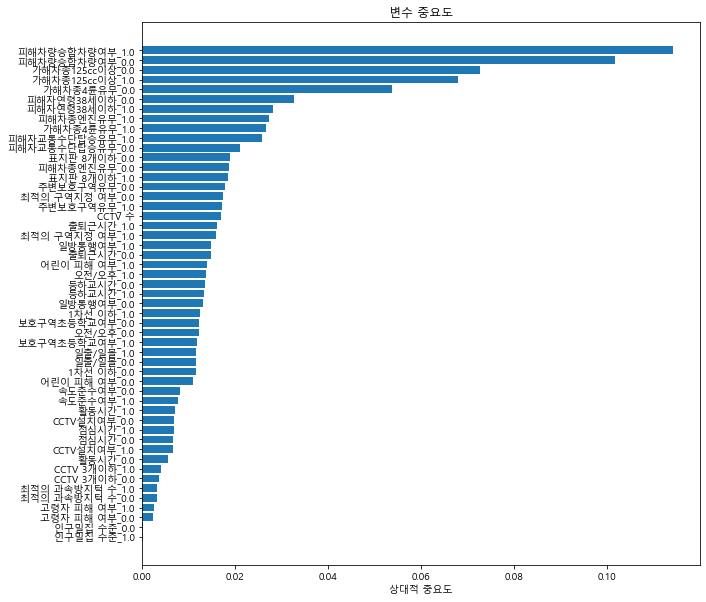

In [135]:
# 랜덤 포레스트 변수 중요도

# random forest pipeline
pipe = make_pipeline(preprocessor,RandomForestClassifier(random_state=0))
pipe.fit(X_train,Y_train)
y_pred = pipe.predict(X_test)
print('테스트 정확도: %.4f'% pipe.score(X_test,Y_test))

# 변수 중요도
rf = RandomForestClassifier(random_state=0)
rf.fit(pd.get_dummies(X_train),Y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.title('변수 중요도')
plt.barh(range(len(indices)), importances[indices],color = 'tab:blue', align ='center')
plt.yticks(range(len(indices)), [pd.get_dummies(X_train).columns[i] for i in indices])
plt.xlabel('상대적 중요도')
plt.show()

# Support Vector Machine

In [29]:
# Training / Test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
Y_train = Y_train.astype('int')   

In [30]:
from sklearn.svm import SVC

pipe_svm = make_pipeline(preprocessor,SVC())

# Parameter list
gs_svm.get_params().keys()
parameters = [{'svc_C': [1,5,10,50,100],
            'svc_gamma':[0.001,0.01,0.1,1],
            'svc_kernel':['rbf']}]

scorers = {'accuracy':make_scorer(accuracy_score),
         'precision': make_scorer(precision_score, average = 'macro'),
         'recall':make_scorer(recall_score, average = 'macro'),
         'f1_macro': make_scorer(f1_score, average ='macro'),
          'f1_weighted':make_scorer(f1_score, average='weighted')}

# GridSearch
gs_svm = GridSearchCV(pipe_svm,param_grid = parameters, scoring = scorers,
                      refit = 'f1_weighted',cv = 50, n_jobs=-1)


gs_svm.fit(X_train,Y_train)

print('최적 매개변수 조합 :%s' %gs_svm.best_params_)
print('CV 정확도 : %4f'%gs_svm.best_score_)

em = gs_svm.best_estimator_
pred = em.pred(X_val)
accuracy_score(Y_val,pred)
# print('테스트 정확도: %3f' % clf_svm.score(X_test,Y_test))

NameError: name 'gs_svm' is not defined

In [ ]:
print(classification_report(Y_test, clf_svm.predict(X_test)))

# LightGBM

pip install lightgbm

In [136]:
# 연속형 변수 
numeric_features = X.select_dtypes("float").columns.to_list()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# 범주형 변수 처리
categorical_features = X.select_dtypes("object").columns.to_list()
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

#컬럼 변환
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

df.to_excel('C:/Users/wnrrh/desktop/data/모델링/model_make.xlsx')

df2에 LGB 모델 구축을 위한 새로운 엑셀 데이터 생성. 

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36240 entries, 0 to 36239
Data columns (total 58 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   시설명            36240 non-null  object  
 1   시간대구분          36240 non-null  float64 
 2   주소             36240 non-null  object  
 3   도로명            36240 non-null  object  
 4   행정동            36240 non-null  object  
 5   행정동 별 인구       36240 non-null  float64 
 6   면적             36240 non-null  float64 
 7   인구밀도           36240 non-null  float64 
 8   자치구            36240 non-null  object  
 9   시설종류           36240 non-null  int64   
 10  구역지정수          36240 non-null  float64 
 11  보호구역도로폭        36240 non-null  float64 
 12  CCTV설치여부       36240 non-null  category
 13  CCTV 수         36240 non-null  float64 
 14  도로표지판 수        36240 non-null  float64 
 15  과속방지턱 수        36240 non-null  float64 
 16  위도             36240 non-null  float64 
 17  경도             36240 non-null  

In [139]:
# Categorical Parameters encoding
from imblearn.over_sampling import SMOTE

labelencoder = LabelEncoder()
df['시설종류'] = labelencoder.fit_transform(df['시설종류']) 
#어린이집:! / 유치원(병설):3 / 유치원(일반):4 / 유치원:2 / 특수학교:6  
# 초등학교:5 / 학원:7 기타:0
cat_features = ['인구밀집 수준','CCTV설치여부','오전/오후','등하교시간','출퇴근시간','속도준수여부','점심시간',
                '일출/일몰','가해차종125cc이상','피해차종엔진유무','어린이 피해 여부','고령자 피해 여부','최적의 구역지정 여부',
                '주변보호구역유무','1차선 이하','최적의 과속방지턱 수','표지판 8개이하','가해차종4륜유무','피해자교통수단탑승유무',
                '피해자연령38세이하','피해차량승합차량여부','CCTV 3개이하','보호구역초등학교여부','활동시간','일방통행여부']

for col in cat_features:
    df[col] = df[col].astype('category')
    
def split(df):
    df_y = df['위험도 군집']
    df_x = df.drop(['시설명','주소','도로명','행정동','행정동 별 인구','면적','인구밀도','자치구','구역지정수','보호구역도로폭','CCTV 수',
                    '도로표지판 수','과속방지턱 수','위도','경도','tmp','사망자수','경상자수','중상자수','부상신고자수','가해운전자 차종',
                    '피해운전자 차종','피해운전자 연령','사고 수','통행량 도로명','통행량','시간대구분','속도','총생활인구수','시설종류',
                    '위험도 군집','cluster_label','위험도'],axis=1, inplace=False)

    X_train,X_test,Y_train,Y_test = train_test_split(df_x,df_y,test_size=0.2, stratify=df_y,random_state=0)
    
    
    return X_train,X_test,Y_train,Y_test
smote = SMOTE(random_state=0)
x_train_over, y_train_over = smote.fit_resample(X_train,Y_train)
X_train,X_test,Y_train,Y_test = split(df)

# X_train,Y_train = ADASYN(random_state=25).fit_resample(X_train,Y_train)

In [140]:
print(X_train.shape,Y_train.shape)

(28992, 25) (28992,)


In [141]:
# LightGBM

from lightgbm import LGBMClassifier
import lightgbm as lgb

# 파라미터 값 설정
params = {'learning_rate':0.05,
          'max_depth': 10,
          'num_iterations':1000,
          'boosting_type':'gbdt',
          
          'sub_feature':0.5,
          'num_leaves' : 10,
          'min_data':50,
          'min_child_samples':20,
          'subsample':0.8
         }

# 그리드서칭 시행할 하이퍼파라미터
gridParams = {'max_depth':[3,5,7],
            'learning_rate':[0.01, 0.05, 0.1, 0.2],
            'num_iteration':[1000],
            'min_child_weight':[5,10,20]}

# 측도 다양하게 사용
scorers = {'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average = 'macro'),
    'f1_macro': make_scorer(f1_score, average = 'macro'),
    'f1_weighted': make_scorer(f1_score, average = 'weighted')}


# 모델 만들기 
lgb_model_GS = lgb.LGBMClassifier(boosting_type= 'gbdt', objective='multiclass', metric='multi_logloss', num_class=3, categorical_feature=cat_features,
                               learning_rate = params['learning_rate'], max_depth = params['max_depth'], num_iterations = params['num_iterations'], 
                               num_leaves = params['num_leaves'], 
                               min_data = params['min_data'], min_child_samples = params['min_child_samples'], subsample=params['subsample'],
                               n_jobs = 6, random_state =2020)  
# 그리드 만들기
grid = GridSearchCV(lgb_model_GS, gridParams, scoring=scorers, refit='f1_weighted', return_train_score=True,
                    verbose=0, cv=2, n_jobs=2)

# 그리드 실행
grid.fit(X_train, Y_train) 

# GridSearchCV 결과를 추출해 데이터 프레임으로 반환
scores_df = pd.DataFrame(grid.cv_results_)

C:\Users\wnrrh\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\wnrrh\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\wnrrh\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\wnrrh\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=50. Current value: min_data_in_leaf=50
[LightGBM] [Warning] num_iterations is set=1000, num_iteration=1000 will be ignored. Current value: num_iterations=1000


In [142]:
# 최적의 하이퍼파라미터로 업데이트
params['learning_rate'] = grid.best_params_['learning_rate']
params['max_depth'] = grid.best_params_['max_depth']
params['min_child_weight'] = grid.best_params_['min_child_weight']
params['num_iterations'] = grid.best_params_['num_iteration']

estimator_best = grid.best_estimator_

y_pred_best = lgb_model_GS.fit(X_train,Y_train, categorical_feature = 'auto')

C:\Users\wnrrh\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\wnrrh\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\wnrrh\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [143]:
# 결과
print(classification_report(Y_test, lgb_model_GS.predict(X_test)))

              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99      7117
         2.0       0.55      0.62      0.58       129
         3.0       0.00      0.00      0.00         2

    accuracy                           0.98      7248
   macro avg       0.51      0.54      0.53      7248
weighted avg       0.99      0.98      0.98      7248



In [144]:
# 교차검증
scores_lgb = cross_val_score(lgb_model_GS, X_train, Y_train, scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores_lgb),np.std(scores_lgb)))

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=50. Current value: min_data_in_leaf=50


C:\Users\wnrrh\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\wnrrh\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\wnrrh\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\wnrrh\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\wnrrh\anaconda3\lib\site-

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=50. Current value: min_data_in_leaf=50


C:\Users\wnrrh\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\wnrrh\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\wnrrh\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=50. Current value: min_data_in_leaf=50


C:\Users\wnrrh\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\wnrrh\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\wnrrh\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=50. Current value: min_data_in_leaf=50


C:\Users\wnrrh\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\wnrrh\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\wnrrh\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=50. Current value: min_data_in_leaf=50
CV 정확도: 0.983 +/- 0.002


The list of features with 0 importance: 
['고령자 피해 여부', '피해자교통수단탑승유무']
The list of features with 0 importance: 
['고령자 피해 여부', '피해자교통수단탑승유무']


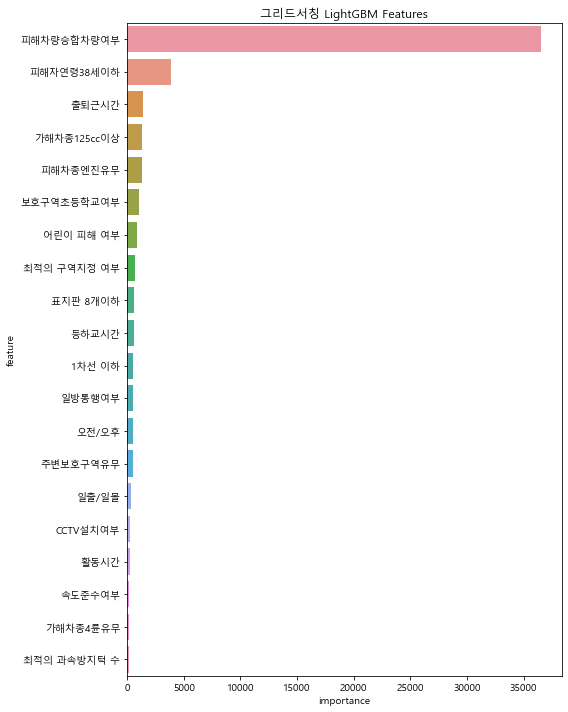

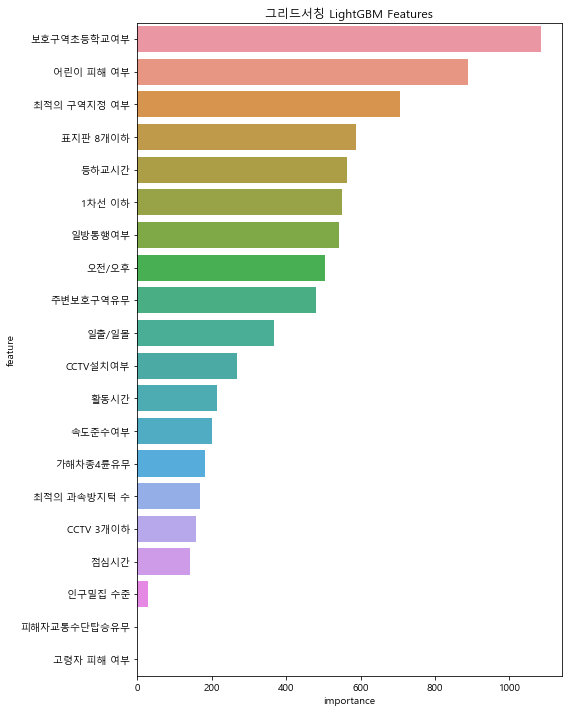

In [145]:
def display_importances(feature_importance_df_, doWorst=False, n_feat=50):

    # 변수 중요도 그리기 
    if not doWorst:
        cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:n_feat].index        
    else:
        cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[-n_feat:].index
    
    mean_imp = feature_importance_df_[["feature", "importance"]].groupby("feature").mean()

    global df_2_neglect 
    df_2_neglect = mean_imp[mean_imp['importance'] < 1e-3]
    print('The list of features with 0 importance: ')
    print(df_2_neglect.index.values.tolist())
    del mean_imp, df_2_neglect
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('그리드서칭 LightGBM Features')
    plt.tight_layout()
    #plt.savefig('lgbm_importances.png')
    
importance_df = pd.DataFrame()
importance_df["feature"] = X_train.columns.tolist()      
importance_df["importance"] = lgb_model_GS.booster_.feature_importance('gain')
display_importances(feature_importance_df_=importance_df, n_feat=20)

# 변수 중요도 출력
display_importances(feature_importance_df_=importance_df, doWorst=True, n_feat=20)